# Week X - Support Vector Machines (SVMs)

<hr style="border:2px solid gray">

# Index: <a id='index'></a>
1. [Useful sklearn Features](#sklearn)
1. [Introduction to SVMs](#SVM_intro)
1. [Linear SVM Classifiers](#linear_SVM)
1. [Nonlinear SVM Classifiers](#nonlinear_SVM)
1. [Kernel Tricks](#kernel)
1. [SVM Regressors](#SVR)
1. [Appendix](#appendix)
    1. [Mathematics of SVM Classifiers (SVCs)](#SVM_app)
    1. [Mathematics of Kernel Tricks](#kernel_app)
    1. [A Worked Kernel Trick Example](#kernel_ex_app)
    1. [Mathematics of SVM Regressors (SVRs)](#SVR_app) 


<hr style="border:2px solid gray">

# Useful sklearn Features [^](#index) <a id='sklearn'></a>

The majority of this notebook will focus on Support Vector Machines, however this initial section will identify useful SKLearn features you may need to use.


### The sklearn Preprocessor

We have previously used and discussed the sklearn.preprocessing package in ML Basics 1. As a reminder, preprocessing can take raw data and transform it into a form better suited for training a model. In this section we will reiterate some key features, as well as introduce new uses:

- We can transform the **range** of the data, both linearly and non-linearly. Many ML approaches expect the training data to fall in a given range (say between -1 and 1). Instances far outside this expected range may unduly skew the learning process. 
    - An example of altering the range is by **normalising** the dataset. <br><br>
    

- We can **encode** categorical features. ML algorithms generally use numbers to identify each category. However much of the data will not have numerial categories but instead groups like 'Male' or 'Likes Horror Films'. The preprocessor has functions that will transform these group categories into numbers.
    - An example of this is [**One-Hot Encoding**](https://www.educative.io/blog/one-hot-encoding), where data are classed as either belonging to a category (1) or not (0). <br><br>

- We can turn a continuous variable into a series of categories - this is called **discretisation**.
    - For example, we could convert our data to a binary choice (such as falling above or below as certain threshold) <br><br>

- We can generate **imputs for missing values**. As discussed in ML Basics 1, this process should be performed with care. <br><br>

- We can **generate polynomial features**. 

For more information, please read the detailed sklearn [documentation](https://scikit-learn.org/stable/modules/preprocessing.html).


**Pipelines** (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html#sklearn-pipeline-pipeline)) enable you to sequentially run a list of different transformers followed by a final estimator. This was discussed previously in ML Basics 1.


<div style="background-color:#C2F5DD">

### Exercise

Read through the documentation linked above. Pick out 3 preprocessors and write little examples of their use.
- One should involve encoding categorical features
- One should involve creating polynomial features
- The final preprocessor can be your choice (for example, data imputation or scaling)

### Saving Models

Some models can take a long time to train, and thus it is often beneficial to store the trained model. This cam most easily be achieved with the [**pickle**](https://docs.python.org/3/library/pickle.html) package.

In the example below, we would like to save a K-Nearest Neighbours model trained on the iris dataset.

In [128]:
import numpy as np
import scipy as sp 
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

iris=load_iris()

X_train, X_test, y_train, y_test = train_test_split(iris['data'],iris['target'], test_size=0.2) 


neighbors = 12
weights = "uniform"
iris_knn = KNeighborsClassifier(n_neighbors=neighbors,weights=weights)
iris_knn.fit(X_train,y_train)
pred = iris_knn.predict(X_test)

print(accuracy_score(y_test, pred))

# We can now store our model

import pickle as pk

filename = 'model'
outfile = open(filename,'wb')
pk.dump(iris_knn,outfile)
outfile.close()


0.9333333333333333


Now lets read the model back in. Technically this code cell is not needed here, but we are pretending that this is a separate program being run at a different time, to illustrate how we would do it in practice.

In [129]:
import numpy as np
import scipy as sp 
from sklearn.datasets import load_iris
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import pickle as pk

iris=load_iris()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(iris['data'],iris['target'], test_size=0.5) #different test selection

filename='model'
infile=open(filename,'rb')
knn=pk.load(infile)
pred=knn.predict(X_test)

print(accuracy_score(y_test, pred))

0.9733333333333334


<div style="background-color:#C2F5DD">

### (Quick) Exercise

Rerun the two cells above, but restart the kernel after the first cell has run. This is just to show that the method does work.

<hr style="border:2px solid gray">

# Introduction to SVMs [^](#index) <a id='SVM_intro'></a>

Support Vector Machines (SVMs) are some of the most commonly used ML techiques. They can be in used in both classification (SVCs) and regression problems, although they are more often used in classification in my world. [HoML](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/) is really very clear in describing these and I recommend their description.

Imagine we have an $N$-dimensional feature space. An SVM will then draw an $N-1$ dimensional hyperplane to act as a boundary between the different categories. The aim is to create well-defined boundaries between clusters, such that a data point with a particular set of characteristics is classified with maximum accuracy. SVM aims to find the hyperplane with **maximum separation** between the categories.

SVMs are particularly useful when you have moderate volumes of data (up to around $10^5$ datapoints).

The mathematics behind SVM is included in the Appendix Section [Mathematics of SVM Classifiers (SVCs)](#SVM_app).

<div style="background-color:#FFCCCB">

### Hyperplane
    
'A hyperplane is a subspace which has one fewer dimension than its ambient space (from [Wikipedia](https://en.wikipedia.org/wiki/Hyperplane)). In 2D, the hyperplane is therefore 1D - a line. In 3D, the hyperspace is a plane, and so on. These hyperplanes cannot be curved (a curved line on a 2D plane is not a 1D object).
    

<hr style="border:2px solid gray">

# Linear SVM Classifiers [^](#index) <a id='linear_SVM'></a>

Let's consider two linearly-seperable datasets. 

For this example we will take a subset of the iris dataset. We will only be interested in two types of iris (the setosa or the versicolor i.e. category 0 or 1). The only features we will investigate are petal length and petal width.

In [130]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import datasets

iris = datasets.load_iris()
X = iris["data"][:,(2,3)]# petal length, petal width. (this slice is equivalent to X = iris["data"][:,2:4])
y = iris["target"]
setosa_or_versicolor = (y == 0) | (y == 1) # we only want y-values of 0 or 1. | is the bitwise OR operator.
X = X[setosa_or_versicolor]
y = y[setosa_or_versicolor]

Below we plot both our data and two lines can separate the instances. As we will see, just because a line separates our data, it is not necessarily the optimal separator.

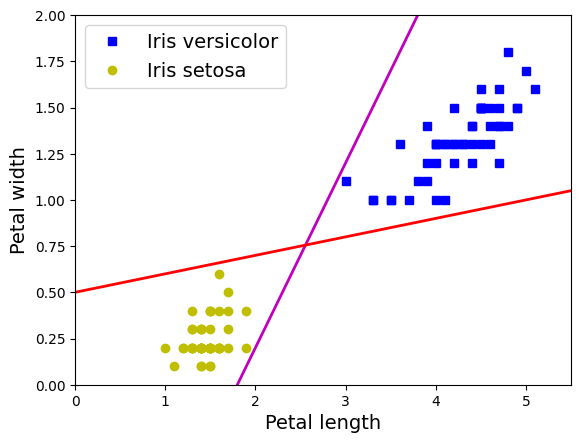

In [131]:
x0 = np.linspace(0, 5.5, 200)

pred_1 = x0 - 1.8
pred_2 = 0.1 * x0 + 0.5

plt.plot(x0, pred_1, "m-", linewidth=2)
plt.plot(x0, pred_2, "r-", linewidth=2)
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)
plt.axis([0, 5.5, 0, 2])

plt.show()

Both of these lines separate the two different iris types, however they are very close to the category limits -  it is very possible that more data of either sort of iris will just cross the boundary and be wrongly classified. SVM helps solve this issue by trying to find the line that provides the **greatest separation**.

SVM takes the hyperparameter _C_. _C_ is the regularisation parameter, and must be a strictly positive float (although it can be very long or very close to 0). Decreasing C corresponds to more regularisation. This is discussed more later, but for now we set C to be a very large number, such that it is effectively infinite. The default value of _C_ is 1. 

We also set the kernel to be linear, again this will be discussed in greater depth later.

In [132]:
from sklearn.svm import SVC

# SVM Classifier model
svm_clf = SVC(kernel="linear", C=100000000.0)
svm_clf.fit(X, y)

SVC(C=100000000.0, kernel='linear')

We can call `svm_clf.coef_[0]` and `svm_clf.intercept_[0]` to find the array of fitted weights (w) and the bias (b). Coordinates $\boldsymbol{x}$ on the decision boundary are those that obey $\sum{(w_i x_i)} +b =0$, which can also be expressed in vector form as $\boldsymbol{w}^T  \boldsymbol{x} + b =0$. In our 2D example, this means the equation of our boundary line is given by $w_0 x_0+w_1 x_1 + b =0$, rearranging to give $x_1 = -\frac{w_0}{w_1}  x_0 - \frac{b}{w_1}$.

The actual support vectors can by calling `svm_clf.support_vectors_`.

To find the margins of our line (i.e. to find the equation of the lines that pass through the support vectors), we add $± \frac{1}{w_1}$


We can use this equation to plot our results.

In [280]:
def plot_svc(svm_clf, xmin, xmax, sv=1):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]

    # At the decision boundary, w0*x0 + w1*x1 + b = 0
    # => x1 = -w0/w1 * x0 - b/w1
    
    x0 = np.linspace(xmin, xmax, 200)
    decision_boundary = -w[0]/w[1] * x0 - b/w[1]
    
    
    # Finding the margins
    margin = 1/w[1]
    gutter_up = decision_boundary + margin
    gutter_down = decision_boundary - margin
    
    # Identifying and marking the support vectors
    if sv:
        svs = svm_clf.support_vectors_
        plt.scatter(svs[:, 0], svs[:, 1], s=180, facecolors='#FFAAAA')
    
    plt.plot(x0, decision_boundary, "k-", linewidth=2)
    plt.plot(x0, gutter_up, "k--", linewidth=2)
    plt.plot(x0, gutter_down, "k--", linewidth=2)

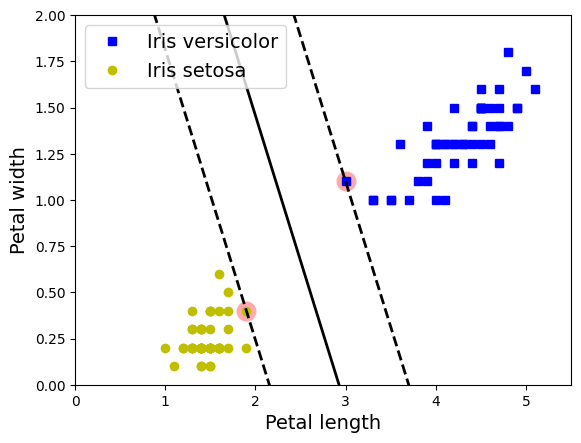

In [134]:
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)


plot_svc(svm_clf, 0, 5.5)
plt.axis([0, 5.5, 0, 2])

plt.show()

We can see that the SVM has indeed chosen the line that has the greatest separation. The two marked points are the nearest two points to the dividing line, and these are the actual 'support vectors'. Adding more data "behind" the support vector makes no difference to the selected boundary.

SVM can very sensitive to feature scale. In the example below (taken from **{HoML}**) you can see the difference the preprocessor scaling can make.

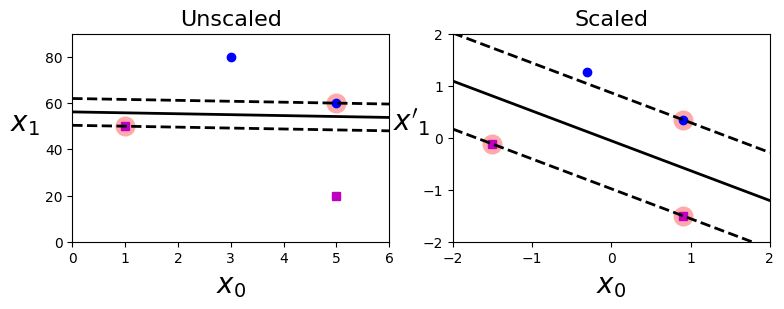

In [135]:
# Arbitrary Data

Xs = np.array([[1, 50], [5, 20], [3, 80], [5, 60]]).astype(np.float64)
ys = np.array([0, 0, 1, 1])

svm_clf = SVC(kernel="linear")
svm_clf.fit(Xs, ys)
    
plt.figure(figsize=(9,2.7))
plt.subplot(121)
plt.plot(Xs[:, 0][ys==1], Xs[:, 1][ys==1], "bo")
plt.plot(Xs[:, 0][ys==0], Xs[:, 1][ys==0], "ms")

plot_svc(svm_clf, 0, 6)

plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x_1$    ", fontsize=20, rotation=0)
plt.title("Unscaled", fontsize=16)
plt.axis([0, 6, 0, 90])

# Now use the sklearn preprocessor to scale the data

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(Xs)

svm_clf.fit(X_scaled, ys)

plt.subplot(122)
plt.plot(X_scaled[:, 0][ys==1], X_scaled[:, 1][ys==1], "bo")
plt.plot(X_scaled[:, 0][ys==0], X_scaled[:, 1][ys==0], "ms")

plot_svc(svm_clf, -2, 2)

plt.xlabel("$x_0$", fontsize=20)
plt.ylabel("$x'_1$  ", fontsize=20, rotation=0)
plt.title("Scaled", fontsize=16)
plt.axis([-2, 2, -2, 2])

plt.show()

We can see that the scaled plot looks a lot more healthy.

### Soft Margin Classification

The technique we have been using so far is called hard margin classification, and it has two significant issues:
- The method only works on a linearly separable problem
- The method is very sensitive to outliers 

We can examine these issues by introducing outliers into our iris dataset. 

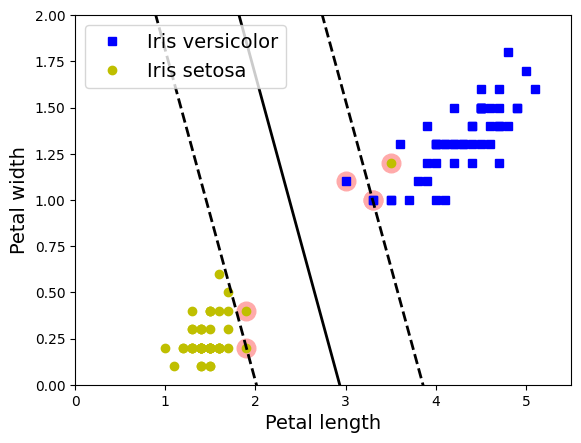

In [136]:
X_mod=X
X_mod=np.append(X,[[3.5,1.2]], axis=0)
y_mod=np.append(y,0)

#Fit the new model and plot
svm_clf = SVC(kernel="linear", C=1)
svm_clf.fit(X_mod, y_mod)

plt.plot(X_mod[:, 0][y_mod==1], X_mod[:, 1][y_mod==1], "bs", label="Iris versicolor")
plt.plot(X_mod[:, 0][y_mod==0], X_mod[:, 1][y_mod==0], "yo", label="Iris setosa")

plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="upper left", fontsize=14)

plot_svc(svm_clf, 0, 5.5)

plt.axis([0, 5.5, 0, 2])

plt.show()

We can see that the data is no longer linearly separable and that there is now a margin violation. 

In these cases, it becomes important to tune our regularisation coeffeicient hyperparameter _C_. 

<div style="background-color:#C2F5DD">

### Exercise

Investigate how varying _C_ affects our model. Take the code above, add a few more "outliers" and then plot the results for C going from small values (say 0.0001) to quite large values (say 1000000). Use these plots to help to understand the behaviour.

<hr style="border:2px solid gray">

# Nonlinear SVM Classifiers [^](#index) <a id='nonlinear_SVM'></a>

Not all problems involve datasets which are linearly separable. However, many of these datasets do become linearly separable if we **add features** with higher polynomial terms (as we did with nonlinear regression in ML Basics 1). 

The most common and straightforward example of this is shown below:

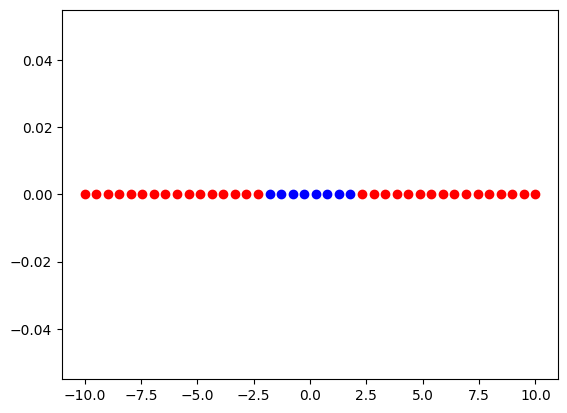

In [137]:
import numpy as np
import pylab as pl

X=np.linspace(-10,10,40)
y= [1 if np.abs(x) > 2 else 0 for x in X]

X_plot1=[X[i] for i in range(len(X)) if y[i]>0]
y_plot1=[0 for i in range(len(X)) if y[i]>0]

X_plot2=[X[i] for i in range(len(X)) if y[i]<1]
y_plot2=[0 for i in range(len(X)) if y[i]<1]

pl.plot(X_plot1,y_plot1,'ro')
pl.plot(X_plot2,y_plot2,'bo')

pl.show()

Each datapoint has one feature, and currently this dataset is not linearly separable. However, it will become linearly separable if add a second feature that is the **square of the first**. Mathematically, we want to add a feature $x_2 = (x_1)^2$

<div style="background-color:#C2F5DD">

### Exercise
    
Demonstrate to yourself that this actually works by using SVM with this new feature. Use `PolynomialFeatures` to generate this feature (see [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html))

### Make Moons

We will now examine another famous ML dataset (or rather a way of making data sets) - these are the SKLearn `make_moons`. 

`make_moons` creates two intertwined data sets which are clearly not lienarly separable, so we will need to add some polynomial features. Below we plot the data set:

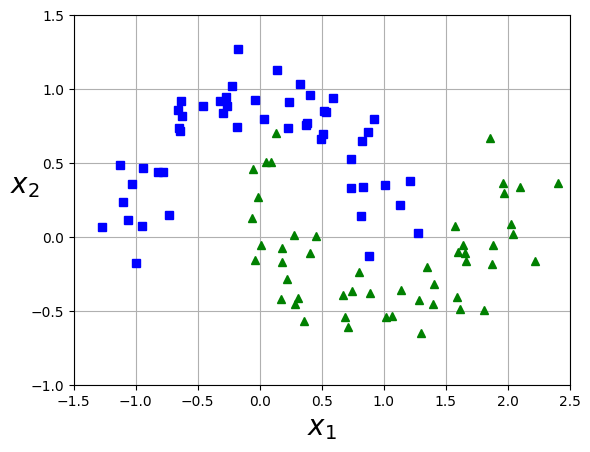

In [138]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=100, noise=0.15, random_state=42)

def plot_dataset(X, y, axes):
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "bs")
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "g^")
    plt.axis(axes)
    plt.grid(True, which='both')
    plt.xlabel(r"$x_1$", fontsize=20)
    plt.ylabel(r"$x_2$", fontsize=20, rotation=0)

plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])
plt.show()

Using sklearn's Pipeline function, we can sequentially call all our data transforms, feature additions and the SVM classifier as just one function. The number of polynomial features we would like to add is specified using the degree keyword argument in PolynomialFeatures.

Having created and fit this ML algorithm, we can then plot our results.

In [139]:
#from sklearn.datasets import make_moons
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

# so lets add a pipline that adds poly features and scales it.

polynomial_svm_clf = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3)),
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="linear", C=1)) # could use LinearSVC(C=10)) as this would be much faster
    ])

polynomial_svm_clf.fit(X, y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('scaler', StandardScaler()),
                ('svm_clf', SVC(C=1, kernel='linear'))])

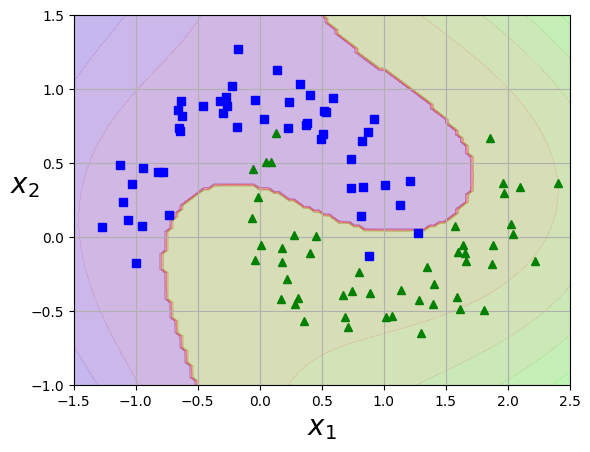

In [140]:
def plot_predictions(clf, axes):
    x0s = np.linspace(axes[0], axes[1], 100)
    x1s = np.linspace(axes[2], axes[3], 100)
    x0, x1 = np.meshgrid(x0s, x1s)
    
    X = np.c_[x0.ravel(), x1.ravel()]
    y_pred = clf.predict(X).reshape(x0.shape)
    y_decision = clf.decision_function(X).reshape(x0.shape)
    plt.contourf(x0, x1, y_pred, cmap=plt.cm.brg, alpha=0.2)
    plt.contourf(x0, x1, y_decision, cmap=plt.cm.brg, alpha=0.1)

plot_predictions(polynomial_svm_clf, [-1.5, 2.5, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.5, -1, 1.5])


plt.show()

Not bad at all. Try it with different values of C and it might get even better or worse.

Adding polynomial features is a useful thing to do and often works. However, it can cause a significant increase in the number of features as you move into higher dimensions, which vastly increases the time required to train our model. Another issue is that as the underlying relationships get more complicated, lower order polynomials no longer work well. 

Fortunately we have another trick up our sleeve  -- a kernel trick.

<hr style="border:2px solid gray">

# Kernel Tricks [^](#index) <a id='kernel'></a>

### Issues with SVM

We must first give a brief overview of how the SVM alorithm works:

Data which cannot be linearly separated in $n$ dimensions can sometimes be separated in some higher dimension, m. We used this technique when we created a quadratic feature in our 1D line exercise. In summary: although there is no $n-1$ dimensional hyperplane to separate the data, there will exist one in $m-1$ dimensions.

In practice, the parameters that describe the hyperplane can be found by calculating a large number of **inner products** in this higher dimensional space.

However, increasing the number of dimensions comes at a cost: we must devote significantly more computational time to find this hyperplane in the new higher dimensional space. The amount of computation scales as $n^2$, so this is not feasible for large datasets.

### How Kernel Tricks can Help

We can actually express all of the inner products in the higher-dimensional space as linear combinations of powers of inner products in the original, lower dimensional space.

This eliminates our need to perform the actual coordinate transformation: we can obtain the results to the higher-dimensional computations while remaining in our lower-dimensional space, saving computational power.

The **kernel trick** is knowing how to find this linear combination. There are many popular kernels to use, however in this notebook we will just consider polynomial and gaussian RBF kernels.

The mathematical formulation of kernel tricks can be found in the Appendix Section [Mathematics of Kernel Tricks](#kernel_app), and a worked example of a kernel trick can be found in the Appendix Section: [A Worked Kernel Trick Example](#kernel_ex_app).

### Polynomial Kernel

We can now build an SVM model with a 3rd degree polynomial kernel. This SVM will take two additional hyperparameters: the degree of the kernel and `coef0` (this determines how much the model is influenced by high degree polynomials as opposed to low degree ones -- the default value is 0).

In [141]:
from sklearn.svm import SVC

poly_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="poly", degree=3, coef0=100, C=5))
    ])
poly_kernel_svm_clf.fit(X, y)

Pipeline(steps=[('scaler', StandardScaler()),
                ('svm_clf', SVC(C=5, coef0=100, kernel='poly'))])

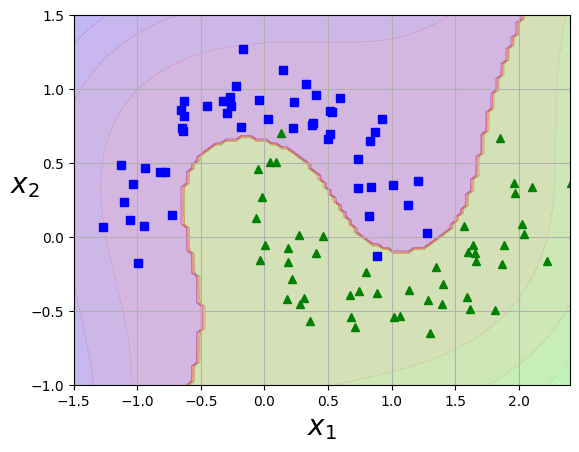

In [142]:
plot_predictions(poly_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])

<div style="background-color:#C2F5DD">

### Exercise

Experiment with changing the values of coef0, C and the number of degrees and see how it affects the fit. Make sure you understand the relationship between these hyperparameters as well, such as by changing multiple hyperparameters at once.
    
Use these tests to consolidate your understanding of the impact of each hyperparameter.    

## Gaussian RBF Kernel

### Similarity Features

Before we considered kernel tricks, we experimented with adding polynomial features to our training data. Another way to add more useful features would be to find the similarity between two points. The most common way of doing this is to define a similarity function, for example the Gaussian *Radial Base Function* (RBF). If using RBF, the similarity between two points $x_1$ and $x_2$ is given by:

$\phi=e^{-\gamma |x_1-x_2|}$

where $\gamma$ is a tunable parameter.

If we did this for every pair of points, the many new features introduced will almost certainly have discriminating power. However, this procedure can result quite an extreme number of features, and it would be helpful to make use of some specialised kernel instead.

### Tuning $\gamma$

$\gamma$ is a hyperparameter; increasing $\gamma$ makes the Gaussian narrower and decreasing it makes it broader. Thus it can be helpful to imagine $\gamma$ acting as a **regulariser** - if $\gamma$ is too large there is a tendency to overfit the model, and if it is too small the model will likely be underfit.

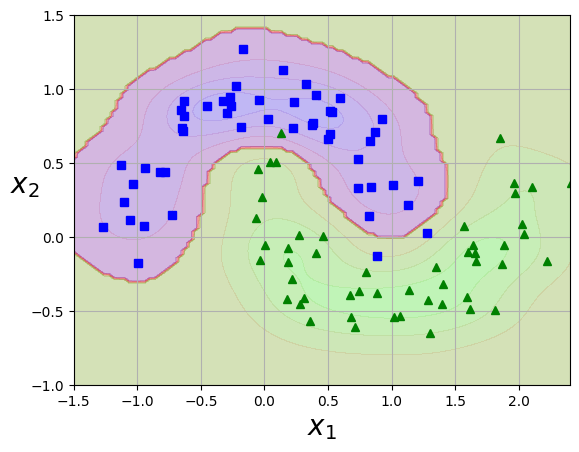

In [143]:
rbf_kernel_svm_clf = Pipeline([
        ("scaler", StandardScaler()),
        ("svm_clf", SVC(kernel="rbf", gamma=5, C=0.01))
    ])
rbf_kernel_svm_clf.fit(X, y)
plot_predictions(rbf_kernel_svm_clf, [-1.5, 2.45, -1, 1.5])
plot_dataset(X, y, [-1.5, 2.4, -1, 1.5])

<div style="background-color:#C2F5DD">

### Exercise
    
This time, investigate the effect of $\gamma$ and C. It is useful to perform this investigation systematically, with suggested ranges of  $0.001 \lt \gamma \lt 50$ and $0.001 \lt C \lt 100000$. 

### Choosing an Appropriate Kernel

There is no magic answer to choosing the right kernel for your problem. It is best to use a linear kernel if your data can be linearly separated.  This notebook has not used `LinearSVC`, however in practice it is much faster than using `SVC(kernel="linear")`. Some experience helps, as does examining your specific problem.  Often a **grid scan** can help to identify the optimal model and hyperparameters.

<hr style="border:2px solid gray">

# SVM Regressors [^](#index) <a id='SVR'></a>

When we use SVM for classification, we are trying to separate the different classes by as great a gap as possible whilst limiting margin violations. In a regression problem, we are trying to do the **opposite** and include as many data points as possible within that margin. Such a model is given the acronym SVR.

If our dataset had no noise, all our data would fall exactly on the regression line - this is unlikely to happen in real life. Thus we introduce the hyperparameter $\epsilon > 0$, which represents our tolerance to noise. To say a datapoint does follow the regression fit, it must lie in a given region (often referred to as the "tube", although this can be confusing in higher dimensions) around the target values. The points inside these region contribute no error to the loss function.

Note that $\epsilon$ is **not** the tube's radius (or N-Dimensional equivalent), but is instead the maximum absolute difference between the predicted and actual target. The image below ([source](https://www.saedsayad.com/support_vector_machine_reg.htm)) shows what that means for a linear and nonlinear kernel (you may ignore $\zeta$ unless you are interest in the maths).

<img src="data_2_DC/svr.png" width="600"/>

To see the formulation for an SVR problem, please read the Appendix Section [Mathematics of SVM Regressors (SVRs)](#SVR_app).

In the cells below, we will look at SVR regression for a linear and polynomial relationship.
_(Ignore any Future Warnings)_

In [282]:
# Find the support vectors
def find_support_vectors(svm_reg, X, y):
    y_pred = svm_reg.predict(X)
    off_margin = (np.abs(y - y_pred) >= svm_reg.epsilon)
    return np.argwhere(off_margin)

# Plot the results
def plot_svm_regression(svm_reg, X, y, axes):
    x1s = np.linspace(axes[0], axes[1], 100).reshape(100, 1)
    y_pred = svm_reg.predict(x1s)
    plt.plot(x1s, y_pred, "k-", linewidth=2, label=r"$\hat{y}$")
    plt.plot(x1s, y_pred + svm_reg.epsilon, "k--")
    plt.plot(x1s, y_pred - svm_reg.epsilon, "k--")
    plt.scatter(X[svm_reg.support_], y[svm_reg.support_], s=180, facecolors='#FFAAAA')
    plt.plot(X, y, "bo")
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.legend(loc="upper left", fontsize=18)
    plt.axis(axes)

/Users/frejaschaap/opt/anaconda3/envs/ML_env/lib/python3.9/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


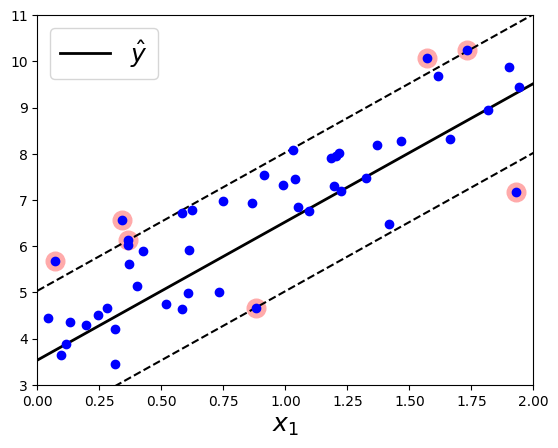

In [283]:
from sklearn.svm import LinearSVR

# First we generate some data
np.random.seed(42)
m = 50
X = 2 * np.random.rand(m, 1)
y = (4 + 3 * X + np.random.randn(m, 1)).ravel()


# Set up the regression
svm_reg = LinearSVR(epsilon=1.5, random_state=42)
svm_reg.fit(X, y)

svm_reg.support_ = find_support_vectors(svm_reg, X, y)

plot_svm_regression(svm_reg, X, y, [0, 2, 3, 11])

<div style="background-color:#C2F5DD">

### Exercise 
Change the value of $\epsilon$ to see how it affects the regression.

In the nonlinear case, we can make use of kernel tricks. For example, if we are fitting what we expect is a polynomial relationship, we can use a polynomial kernel. See the example below.

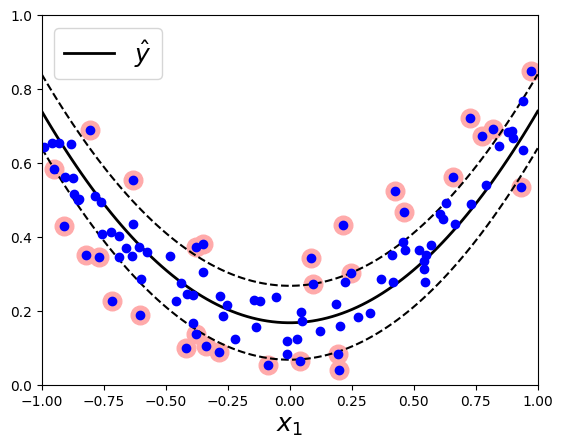

In [284]:
from sklearn.svm import SVR

np.random.seed(42)
m = 100
X = 2 * np.random.rand(m, 1) - 1
y = (0.2 + 0.1 * X + 0.5 * X**2 + np.random.randn(m, 1)/10).ravel()

svm_poly_reg = SVR(kernel="poly", degree=2, C=100, epsilon=0.1, gamma="scale")
svm_poly_reg.fit(X, y)

plot_svm_regression(svm_poly_reg, X, y, [-1, 1, 0, 1])

<div style="background-color:#C2F5DD">

### Exercise

Again, see how this regression plot varies with $\epsilon$.

<hr style="border:2px solid gray">
<hr style="border:2px solid gray">

<div style="background-color:#efdff2">

# Appendix <a id='appendix'></a>

[Return to Index](#index)

In this section, you will find longer pieces of mathematics and code which are **non-examinable**. Please read at your own discretion

- A. [Mathematics of SVM Classifiers (SVCs)](#SVM_app)
- B. [Mathematics of Kernel Tricks](#kernel_app)
- C. [A Worked Kernel Trick Example](#kernel_ex_app)
- D. [Mathematics of SVM Regressors (SVRs)](#SVR_app)   
    

<hr style="border:2px solid gray">

<div style="background-color:#efdff2">

## A. Mathematics of SVM Classifiers [^^](#appendix) <a id='SVM_app'></a>

[Return to relevant section in notes](#SVM_intro) 
    
_References: [sklearn documentation](https://scikit-learn.org/stable/modules/svm.html), MIT: R. Berwick, [An Idiot's Guide to SVMs](https://web.mit.edu/6.034/wwwbob/svm-notes-long-08.pdf), tsmatx: Tsuyoshi Matsuzaki [Mathematical Introduction for SVM and Kernel Functions](https://tsmatz.wordpress.com/2020/06/01/svm-and-kernel-functions-mathematics/)_
    
### Defining the Boundary Conditions
    
We will use the dot production form of a hyperplane to define our parameters. Let $\boldsymbol{w_0}$ be the unit vector perpendicular to the hyperplane, and $\boldsymbol{p}$ some point on the hyperplane such that $\boldsymbol{w_0}^T \boldsymbol{p} = -b_0$, where b is the scaled bias. The vector $\boldsymbol{w_0}$ provides the direction of the boundary, and $b$ defines the position. We can then write the equation of our hyperplane boundary as $\lambda \boldsymbol{w_0}^T  (\boldsymbol{x}- \boldsymbol{p}) =0$, where $\lambda$ is any arbitrary positive scalar. This scalar has no impact on the actual hyperplane and thus can take **any** value.
 
Points 'above' this boundary belong to one category (which we will label as $y_i=1$), whereas points below belong to another (which we will label as $y_i=-1$). 
- If a data point $\boldsymbol{x_i}$ is 'above' the boundary (i.e. $y_i =1$): $\lambda \boldsymbol{w_0}^T (\boldsymbol{x_i}- \boldsymbol{p})>0$
- If a datapoint is below the boundary (i.e. $y_i =-1$): $\lambda \boldsymbol{w_0}^T (\boldsymbol{x_i}- \boldsymbol{p}) < 0$
    
We can combine these conditions into one expression. 
$$ \lambda y_i (\boldsymbol{w_0}^T \boldsymbol{x_i} +b_0) >0$$
    
      
Notice that if $\lambda = 1$, the LHS of this expression is simply the shortest distance from the point $\boldsymbol{x_i}$ to the hyperplane ($y_i$ ensures the value is positive).

<div style="background-color:#efdff2">

### Calculating the Margin
    
Let the smallest distance between any data point and the hyperplane in question be $k$. We can choose lambda to be $\frac{1}{k}$:
    
\begin{equation}
     \lambda y_i (\boldsymbol{w_0}^T \boldsymbol{x_i} +b_0) \ge {k} \lambda \\
     \lambda y_i (\boldsymbol{w_0}^T \boldsymbol{x_i} +b_0) \ge 1
\end{equation}
    
We can define $\boldsymbol{w}$ as having the same direction as $\boldsymbol{w_0}$, but with magnitude $||\boldsymbol{w}|| = \lambda = \frac{1}{k}$. We can also rescale $b_0$ in the same way to obtain the bias, b. This gives:
\begin{equation}
    y_i(\boldsymbol{w}^T \boldsymbol{x_i} +b) \ge 1
\end{equation}    
    
So for a given vector $\boldsymbol{w}$ and bias that define the hyperplane, we know that the margin = k = $\frac{1}{||\boldsymbol{w}||}$. In hard margin classifcation, we simply want to find the value of $\boldsymbol{w}$ that maximises this value whilst still correctly classifying all data points. In soft margin classification, we also account for any outliers.
    
### Support Vectors

b and $\boldsymbol{w}$ are independent. For a given $\boldsymbol{w}$, the ideal b (which dictates the position of the plane) would mean the nearest points to the hyperplane in each category have an **equal margin = k**. If we tried to increase the margin for one point, we would decrease the margin for the other and thus k would **decrease**. These points are the **support vectors**.

<div style="background-color:#efdff2">

### Defining the Minimisation Function
    
We can re-express our maximisation problem and instead attempt to **minimise** ${||\boldsymbol{w}||}$. It would be easier to find the minimum of this function if we could calculate the derivative at all points, however the derivative of $||\boldsymbol{w}||$ does not exist at **0**. To get past this, we can use the fact $f(x) = x^2$ for non-negative $x$ is a monotonically increasing function. Thus minimising ${||\boldsymbol{w}||}$ would be equivalent to minimising:
    $$\frac{1}{2}{||\boldsymbol{w}||}^2$$

    
We are able to express $||\boldsymbol{w}||^2$ as $\boldsymbol{w}^T\boldsymbol{w}$. We can use this to calculate the derivative of our new expression wrt $\boldsymbol{w}$ as $\boldsymbol{w}^T$.
    
In reality, outliers in our dataset means that the hyperplane is unlikely to be a perfect dividor. We can adapt to this by introducing two new variables into our expression. 
- The first is the vector $\boldsymbol{\zeta}$, where $\zeta_i \ge 0$ is the Euclidian distance **scaled by k** (i.e. if the Euclidan distance is r, $\zeta_i$ is  $\frac{r}{k}$) from the $i^{th}$ datapoint to its correct classification region. 
    - If this data point is in the correct region, this distance is simply 0.
    - If the point is closer to the hyperplane than the support vector, but still on the correct side of the boundary (which is allowed to occur with soft margins), $ 0 < \zeta_i < 1$.
    - If the point is on the wrong side of the boundary, $ \zeta_i > 1 $
- The second variable we introduce is the hyperparameter _C_ (the regularisation parameter). This contols how sensitive our model is to outliers. We use these two new variable to rexpress our minimisation problem as:
    
$$\min_{w, b, \zeta} \frac{1}{2}\boldsymbol{w}^T\boldsymbol{w} + C\sum_{i}^{N}\zeta_i$$
    
With a high value of C, minimising $\sum_{i}^{N}\zeta_i$ will be the greatest way to minimise the entire expression - any 'outliers' will have a large impact on our model. With a more moderate C, the model must balance maximising the separation gap whilst minimising the number of and distance to outliers.
    
Previously we assumed all our data was correctly classified. We could therefore use the inequality: $y_i(\boldsymbol{w_0}^T \boldsymbol{x_i} +b_0) \ge k$, where the LHS is the distance from point $\boldsymbol{x_i}$ to the boundary and equality holds at the support vectors. Our outliers are outside this range by $k\zeta_i$, and thus our inequality would only hold for these points if we moved them closer to the boundary by $k\zeta_i$. We can a new inequality for these update conditions:
\begin{equation}
y_i(\boldsymbol{w_0}^Tx_i+b_0)+ k\zeta_i\geq k \\
y_i(\boldsymbol{w}^Tx_i+b)\geq 1 - \zeta_i 
\end{equation}   

( $\zeta_i=0$ for non-outliers, and so it is clear this inequality holds for all points).
    
_Reference: (https://tsmatz.wordpress.com/2020/06/01/svm-and-kernel-functions-mathematics/)_

<div style="background-color:#efdff2">
    
### Lagrangian Solution
    
*We will only discuss the method of Lagrangian Solutions, and will not discuss how this differs from KTT*
    
From these point forward, we will be considering only the hard margin classification problem (all points are correctly classified) just so we are working with fewer variables. The same logic can be applied to the soft margin form.
    
We have a minimisation problem with an inequality constraint. This means we can solve our problem by using either the **primal** or **dual** form of the Lagrangian. This section will not detail the maths about how these two forms arise, however Stanford's lovingly titled [Lagrangian Duality for Dummies](https://www-cs.stanford.edu/people/davidknowles/lagrangian_duality.pdf) has an excellent explanation.
    
**Solving the Primal Lagrangian**
    
It is likely you are more familiar with the primal form of a Lagrangian problem: 
    
$$\min_{w, b} \frac{1}{2}\boldsymbol{w}^T\boldsymbol{w} \newline
y_i(\boldsymbol{w}^T \boldsymbol{x_i} +b) -1 \ge 0    $$
    
Thus our primal Lagrangian (which we aim to minimise) is written as
    $$\mathcal{L}_p(\boldsymbol{w}, b, \boldsymbol{a}) = \frac{1}{2}\boldsymbol{w}^T\boldsymbol{w} - \sum a_i (y_i(\boldsymbol{w}^T \boldsymbol{x_i} +b) -1) \newline
    \mathcal{L}_p(\boldsymbol{w}, b, \boldsymbol{a}) = \frac{1}{2}\boldsymbol{w}^T\boldsymbol{w} - \sum a_i (y_i(\boldsymbol{w}^T \boldsymbol{x_i} +b) +\sum a_i$$ 
    
where **a** is the vector containing the Lagrangian multipliers $a_i$, where $a_i \ge 0$.
    
The differentials wrt **w** and b are 0, and so we can solve our problem.
\begin{equation}    
    \frac{\partial \mathcal{L}_p}{\partial \mathbf{w}} = \boldsymbol{w}^T - \sum a_i y_i \boldsymbol{x_i^T} =0 
    \implies \boldsymbol{w} = \sum a_i y_i \boldsymbol{x_i} \\
    \frac{\partial \mathcal{L}_p}{\partial b} = \sum a_i y_i = 0
\end{equation}   
    
**The Form of the Dual Lagrangian**
    
We now have conditions for the primal problem. In the dual problem, we wish to choose **a** so as to **maximise** the minimised primal Lagrangian.
    $$\mathcal{L}_D(\boldsymbol{a}) = 
    \frac{1}{2} (\sum_i a_i y_i \boldsymbol{x_i}^T)(\sum_j a_j y_j\boldsymbol{x_j}) -
    \sum_i a_i y_i  (\sum_j a_j y_j\boldsymbol{x_j^T}) \boldsymbol{x_i} 
    -b \sum_i a_i y_i + \sum a_i \newline
    = \sum a_i - \frac{1}{2} \sum_i \sum_j a_i a_j y_i y_j \boldsymbol{x_i}^T \boldsymbol{x_j}$$
    
(Note we have used the conditions: $\boldsymbol{w} = \sum a_i y_i \boldsymbol{x_i}$ and $\sum a_i y_i = 0$)
    
At the moment, there may not seem much use for this dual form. However, it will become useful when we introduce kernel tricks.    

<hr style="border:2px solid gray">

<div style="background-color:#efdff2">

## B. Mathematics of Kernel Tricks [^^](#appendix) <a id='kernel_app'></a>

[Return to relevant section in notes](#kernel) 
    
Our data is no longer linear seperable, so we must map our data onto a higher dimension. This mapping function  has the symbol $\phi$. $\phi(\boldsymbol{x})$ is thus a vector in a higher dimension than $\boldsymbol{x}$. The **kernel** is the inner product of two of these mapped vectors: $K(\boldsymbol{x_i}, \boldsymbol{x_j}) = ( \phi(\boldsymbol{x_i}) \cdot \phi(\boldsymbol{x_j}) )$
    
Our dual Lagrangian we wish to maximise in this higher dimension can be written as:

$$\mathcal{L}_D(\boldsymbol{a})= \sum_i\alpha_i - \frac{1}{2} \sum_i \sum_j a_i a_j y_i y_j \phi(\boldsymbol{x_i})^T \phi(\boldsymbol{x_j}) \newline
\sum_i\alpha_i - \frac{1}{2} \sum_i \sum_j a_i a_j y_i y_j K(\boldsymbol{x_i}, \boldsymbol{x_j})$$
    
To see how this helps us, we will use the example of the polynomial kernel.

$$ K(\boldsymbol{x},\boldsymbol{x'}) = \phi(\boldsymbol{x})^T\phi(\boldsymbol{x'})  = (1+\boldsymbol{x}^T\boldsymbol{x'})^d$$

for any $d>0$.

This is important. One can see clearly that regardless of how many features we wish to add to the dataset, we only need to know the results of the dot products in the original, lower dimensional space. Thus we can implicitly perform our computations in the higher dimensional space without such a large computational cost.
    
For more information on kernel tricks, please see [Berkeley's Lecture Notes](https://people.eecs.berkeley.edu/~jordan/courses/281B-spring04/lectures/lec3.pdf) by Michael I. Jordan or (for even greater depth) [Stanford's Lecture Notes](https://cs229.stanford.edu/lectures-spring2022/main_notes.pdf) by Andrew Ng.

<hr style="border:2px solid gray">

<div style="background-color:#efdff2">
    
## C. A Worked Kernel Trick Example [^^](#appendix) <a id='kernel_ex_app'></a>  
    
[Return to relevant section in notes](#kernel) 
    
_References: Medium: Drew Wilimitis, [The Kernel Trick in Support Vector Classification](https://towardsdatascience.com/the-kernel-trick-c98cdbcaeb3f#:~:text=The%20kernel%20function%20has%20a,often%20called%20the%20kernel%20trick), Wikipedia: [Polynomial kernel](https://en.wikipedia.org/wiki/Polynomial_kernel#:~:text=Definition,order%20terms%20in%20the%20polynomial.)_

To see how this helps us, we will use the example of a polynomial kernel.
    
In general, a d-order polynomial kernels take the following form:

$$ K(\boldsymbol{x},\boldsymbol{x'}) = \phi(\boldsymbol{x})^T\phi(\boldsymbol{x'})  = (c+\boldsymbol{x}^T\boldsymbol{x'})^d$$

where c is a non-negative constant.

We will consider an example originally in 2D (a linear kernel means no kernel tricks).

In [272]:
import sklearn, sklearn.datasets

Accuracy: 0.637


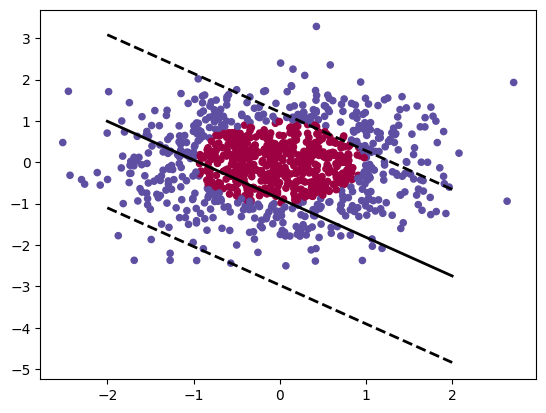

In [281]:
n_samples=1000
X, Y = sklearn.datasets.make_gaussian_quantiles(mean=None, 
    cov=0.7, n_samples=n_samples, n_features=2, n_classes=2, 
    shuffle=True, random_state=None)

svm_2d = SVC(kernel="linear", C=1)
svm_2d.fit(X, Y)


plt.scatter(X[:,0],X[:,1], c=Y, s=20, cmap=plt.cm.Spectral)

plot_svc(svm_2d, -2, 2, sv=0)

print('Accuracy:',svm_2d.score(X, Y)) 
#This is the mean accuracy of our model. Randomly assigning points should give 0.5

plt.show()


<div style="background-color:#efdff2">
    
 As expected, a traditional SVM model is unable to act as a classifier. We must instead move to a higher dimension. One way to do this is to use the mapping:
\begin{equation}
\phi (\boldsymbol{x}) = \phi (\begin{pmatrix} x_{1} \\x_{2} \end{pmatrix}) =
    \begin{pmatrix} x_{1}^2 \\ \sqrt{2} (x_{1} x_{2}) \\ x_{2}^2 \end{pmatrix}
\end{equation}

In [274]:
X=np.array(X)
X_n_0 = X[:,0]**2
X_n_1 = 2**0.5 * X[:,0] * X[:,1]
X_n_2 = X[:,1]**2
X_n =np.array([X_n_0, X_n_1, X_n_2])
X_n = X_n.transpose()

<div style="background-color:#efdff2">

This transformed data is plotted in 3D below. Feel free to change the viewing angle and point opacity as desired. It does appear that a plane could separate the two data classes.

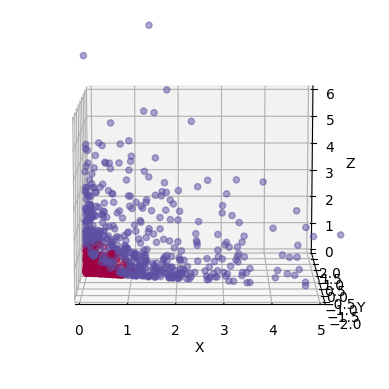

In [275]:
ax = plt.axes(projection='3d')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.view_init(10, 270)
ax.set_xlim3d(0,5)
ax.set_ylim3d(-2,2)
ax.set_zlim3d(0,6)
ax.scatter3D(X_n_0, X_n_1, X_n_2, c=Y, cmap=plt.cm.Spectral, alpha=0.5)
plt.show()

<div style="background-color:#efdff2">

We will fit our newly mapped data using as SVM classifier, again with a linear kernel, and plot the results. 3D plots can be difficult to interpret, so feel free to change the viewing angle, point opacity and how much we have zoomed in on our data.

In [276]:
svm_3d = SVC(kernel="linear", C=1)
svm_3d.fit(X_n, Y)
print ('Accuracy:',svm_3d.score(X_n, Y)) 

Accuracy: 0.985


In [277]:
def plot_svc_3d(svm_clf, xmin, xmax, ymin, ymax, ax):
    w = svm_clf.coef_[0]
    b = svm_clf.intercept_[0]
    
    x_lin = np.linspace(xmin, xmax, 200)
    y_lin = np.linspace(ymin, ymax, 200)
    xx, yy = np.meshgrid(x_lin, y_lin)
    coords = (np.c_[xx.ravel(), yy.ravel()]).transpose()
    
    Z = -w[0]/w[2] * coords[0] - w[1]/w[2] * coords[1] - b/w[2]
    Z[Z < 0] = np.nan
    ax.plot(coords[0], coords[1], Z , "k",  alpha=0.6)
    
    return (Z)


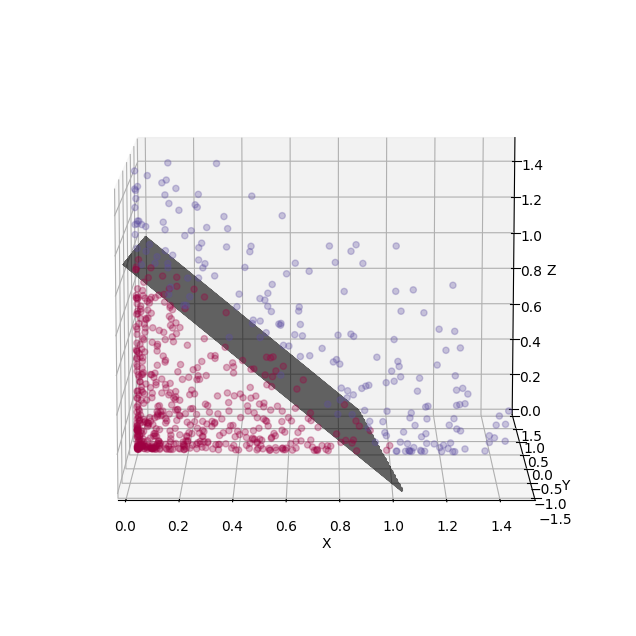

In [278]:
plt.figure( figsize= (8,8))
ax = plt.axes(projection='3d')
ax.view_init(10, 270)

# To make the final plot clearer, we are not displaying some points
X_n_0[X_n_0 > 1.5]= np.nan
X_n_1[abs(X_n_1) > 1.5]= np.nan
X_n_2[X_n_2 > 1.5]= np.nan

ax.scatter3D(X_n_0, X_n_1, X_n_2, c=Y, cmap=plt.cm.Spectral, alpha=0.3)
Z = plot_svc_3d(svm_3d, 0,1.5, -1.5,1.5, ax)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_xlim3d(0,1.5)
ax.set_ylim3d(-1.5,1.5)
ax.set_zlim3d(0,1.5)
plt.show()

<div style="background-color:#efdff2">
    
### The trick
    
In this analysis, we will instead simply calculate the kernel:
\begin{equation}
K(\boldsymbol{x}, \boldsymbol{x'}) = \phi (\boldsymbol{x}) \cdot \phi (\boldsymbol{x'}) = \left (\begin{array}{c} x_{1}^2 \\ \sqrt{2} (x_{1} x_{2}) \\ x_{2}^2 \end{array}\right) 
   \cdot \left (\begin{array}{c} {x'}_{1}^2 \\ \sqrt{2} ({x'}_{1} {x'}_{2}) \\ {x'}_{2}^2 \end{array}\right) \\
    = x_{1}^2 {x'}_{1}^2 + 2 x_{1} x_{2} {x'}_{1} {x'}_{2} + x_{2}^2 {x'}_{2}^2
    = {(x_{1} {x'}_{1} + x_{2} {x'}_{2})}^2 \\
    = {(\boldsymbol{x}^T \boldsymbol{x'})}^2
\end{equation}    
    
This is simply a function of the inner product in a lower dimension.  We could have saved signifcant computational time by computing these untransformed inner products instead. Note this also matches the form of the polynomial kernel we stated early, with c=0 and d=2 (a polynomial kernel with c = 0 is called **homogenous**)

This time, we can try to fit our initial data using an SVM with a polynomial kernel. We will set coef0 =0 (c in the equation above) and degree = 2.

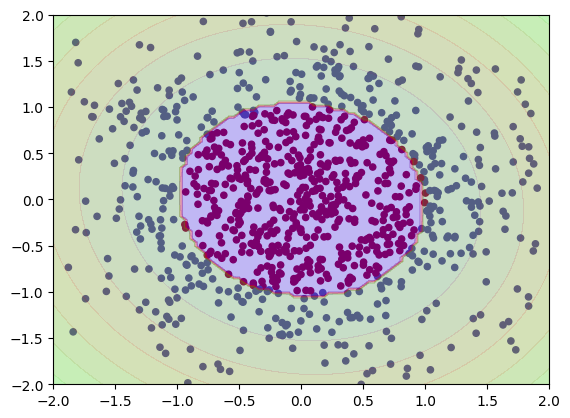

Accuracy: 0.98


In [279]:
svm_ex_poly = SVC(kernel="poly", degree=2, coef0=0, C=1)
svm_ex_poly.fit(X, Y)

plt.scatter(X[:,0],X[:,1], c=Y, s=20, cmap=plt.cm.Spectral)

plot_predictions(svm_ex_poly, [-2, 2, -2, 2])

plt.axis([-2, 2, -2, 2])
plt.show()
print ('Accuracy:',svm_ex_poly.score(X, Y))

<hr style="border:2px solid gray">

<div style="background-color:#efdff2">
    
## D. Mathematics of SVM Regressors (SVRs) [^^](#appendix) <a id='SVR_app'></a>  
    
[Return to relevant section in notes](#SVR) 
    
_References: sklearn's [documentation](https://scikit-learn.org/stable/modules/svm.html)_
    
We want our predicted model to be **as general as possible**, and so we want to **maximise** the prediction error whilst still maintaining an error ideally less than $\epsilon$. This is different to the regression approaches we have seen before, where we simply wanted to minimise error.
    
This is because in SVR we want to control our model's tolerance for error through a hyperparameter. Maximising the margin whilst still maintaining our constraint should make our model perform better on unseen data.
    
Therefore this is an extremely similar problem to SVC, except with a different constraint.
    
### "Hard Margin" SVR
    
A data point $\boldsymbol{x_i}$ has a label $y_i$. The model predicted label value ($y'_i$) is given by $\boldsymbol{w}^T \boldsymbol{x_i}+b$. We can therefore write our constraint as:
    
$$| y_i - y'_i| \le \epsilon \newline
|y_i - (\boldsymbol{w}^T \boldsymbol{x_i}+b)| \le \epsilon $$
    
and, just like in SVC, we wish to minimise 
$$\frac{1}{2}\boldsymbol{w}^T\boldsymbol{w}$$
    
### Including Outliers
    
Not every point will be inside the $\epsilon$ "tube". We introduce the terms $\zeta_i$ to be the distance vertically 'above' the tube a datapoint actually is,  and \$\zeta_i^*$ to represent the distance below. See the image in the SVR section to see what this means. If a point is in the region, both values of $\zeta$ will be 0.
    
We want to balance these errors with maximising the margin. So our new function we wish to minimise is:
$$\frac{1}{2}\boldsymbol{w}^T\boldsymbol{w} + C \sum (\zeta_i + \zeta_i^*)$$
where C is a hyperparameter that acts in the same way as for SVM.
    
Since we are now allowing points to be outside the region, we also have new constraints:
    
$$ y_i - (\boldsymbol{w}^T \boldsymbol{x_i}+b) \le \epsilon + \zeta_i \newline
\boldsymbol{w}^T \boldsymbol{x_i}+b - y_i \le \epsilon + \zeta_i^* \newline
\zeta_i, \zeta_i^* \ge 0$$   
    
We can solve this in the same way we did for SVC, including with the use of kernel tricks.  